In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [5]:
#standard imports
import time
import numpy as np
import h5py


In [6]:
#We're not using the GPU here, so we set the 
#"CUDA_VISIBLE_DEVICES" environment variable to -1
#which tells tensorflow to only use the CPU

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

## Gradient Descent

In [7]:
#let's define a model which "believes" that the output data
#is scalar power of a scalar input, e.g. :
#      y ~ x^p

#defining the scalar input data variable 
batch_size = 200

#the "placeholder" mechanis is similar in effect to
#            x = tf.get_variable('x', shape=(batch_size,), dtype=tf.float32)
#except we don't have to define a fixed name "x"
x = tf.placeholder(shape=(batch_size,), dtype=tf.float32)

#define the scalar power variable
initial_power = tf.zeros(shape=())
power = tf.get_variable('pow', initializer=initial_power, dtype=tf.float32)

#define the model
model = x**power

#the output data needs a variable too
y = tf.placeholder(shape=(batch_size,), dtype=tf.float32)

In [8]:
#the error rate of the model is mean L2 distance across 
#the batch of data
power_loss = tf.reduce_mean((model - y)**2)

In [9]:
#now, our goal is to use gradient descent to 
#figure out the parameter of our model -- namely, the power variable
grad = tf.gradients(power_loss, power)[0]

In [10]:
#Let's fit (optimize) the model.   
#to do that we'll have to first of course define a tensorflow session
sess = tf.Session()

In [11]:
#... and initialize the power variable
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [12]:
#ok ... so let's test the case where the true input-output relationship
#is x --> x^2
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

In [13]:
#OK
initial_guess = 0
assign_op = tf.assign(power, initial_guess)
sess.run(assign_op)

gradval = sess.run(grad, feed_dict={x: xval, y: yval})

In [14]:
gradval

-1.5306325

In [15]:
#ok so this is telling us to do:

new_guess = initial_guess + -1 * (gradval)
print(new_guess)

1.53063249588


In [16]:
#ok so let's assign the new guess to the power variable
assign_op = tf.assign(power, new_guess)
sess.run(assign_op)

#... and get the gradient again
gradval = sess.run(grad, feed_dict={x: xval, y: yval})

gradval

-0.56193405

In [17]:
new_guess = new_guess + -1 * (gradval)
print(new_guess)

2.09256654978


In [18]:
#... and one more time ...
assign_op = tf.assign(power, new_guess)
sess.run(assign_op)

#... get the gradient again
gradval = sess.run(grad, feed_dict={x: xval, y: yval})
print('gradient: %.3f', gradval)

#... do the update
new_guess = new_guess + -1 * (gradval)
print('power: %.3f', new_guess)

#ok so we're hovering back and forth around guess of 2.... which is right!

('gradient: %.3f', 0.17790559)
('power: %.3f', 1.9146609604358673)


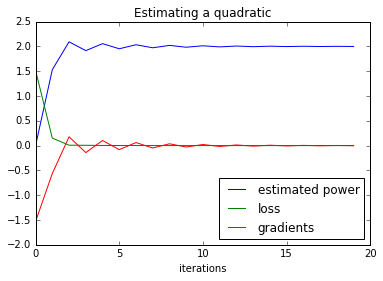

In [19]:
#OK let's do this in a real loop and keep track of useful stuff along the way
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

#start the guess off at 0 again
assign_op = tf.assign(power, 0)
sess.run(assign_op)

#let's keep track of the guess along the way
powers = []

#and the loss, which should go down
losses = []

#and the grads just for luck
grads = []

#let's iterate the gradient descent process 20 timesteps
num_iterations = 20

#for each timestep ...
for i in range(num_iterations):
    
    #... get the current derivative (grad), the current guess of "power"
    #and the loss, given the input and output training data (xval & yval)
    cur_power, cur_loss, gradval = sess.run([power, power_loss, grad], 
                                        feed_dict={x: xval, y: yval})

    #... keep track of interesting stuff along the way
    powers.append(cur_power)
    losses.append(cur_loss)
    grads.append(gradval)
    
    #... now do the gradient descent step
    new_power = cur_power - gradval
    
    #... and actually update the value of the power variable
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
    #and then, the loop runs again
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.plot(grads, label='gradients')
plt.xlabel('iterations')
plt.legend(loc='lower right')
plt.title('Estimating a quadratic')

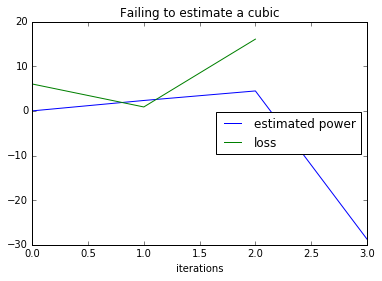

In [20]:
##ok now let's try that again except where y ~ x^3

#all we need to do is change the data
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

#The rest of the code remains the same
assign_op = tf.assign(power, 0)
sess.run(assign_op)

powers = []
losses = []
grads = []

num_iterations = 20
for i in range(num_iterations):    
    cur_power, cur_loss, gradval = sess.run([power, power_loss, grad], 
                                        feed_dict={x: xval, y: yval})
    powers.append(cur_power)
    losses.append(cur_loss)
    grads.append(gradval)

    new_power = cur_power - gradval

    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.xlabel('iterations')
plt.legend(loc='center right')
plt.title('Failing to estimate a cubic')
    
#wait ... this did *not* work.  why? 

In [21]:
#whoa ... the loss must have diverged to infinity (or close) really early
losses
#why? 

[6.0235572,
 0.87862968,
 16.070698,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [22]:
#let's look at the gradients
grads
#hm.  the gradient was getting big at the end. 

[-2.3299172,
 -2.1364195,
 33.202091,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [23]:
#after all, the taylor series only works in the close-to-the-value limit. 
#we must have been been taking too big steps.  
#how do we fix this? 

### With Learning Rate

In [24]:
def gradient_descent(loss, 
                     target,
                     initial_guess,
                     learning_rate,
                     training_data,
                     num_iterations):
    
    #assign initial value to the target
    initial_op = tf.assign(target, initial_guess)

    #get the gradient
    grad = tf.gradients(loss, target)[0]
    
    #actually do the gradient descent step directly in tensorflow
    newval = tf.add(target, tf.multiply(-grad, learning_rate))
    
    #the optimizer step actually performs the parameter update
    optimizer_op = tf.assign(target, newval)
    
    #NB:  none of the four steps above are actually running anything yet
    #They are just formal graph computations. 
    #to actually do anything, you have to run stuff in a session. 
 
    #set up containers for stuff we want to keep track of
    targetvals = []
    losses = []
    gradvals = []
    
    #first actually run the initialization operation
    sess.run(initial_op)
    
    #now take gradient steps in a loop
    for i in range(num_iterations):
        #just by virtue of calling "run" on the "optimizer" op, 
        #the optimization occurs ... 
        output = sess.run({'opt': optimizer_op,
                           'grad': grad, 
                           'target': target,
                           'loss': loss
                          }, 
                          feed_dict=training_data)
        targetvals.append(output['target'])
        losses.append(output['loss'])
        gradvals.append(output['grad'])
                
    return losses, targetvals, gradvals
    

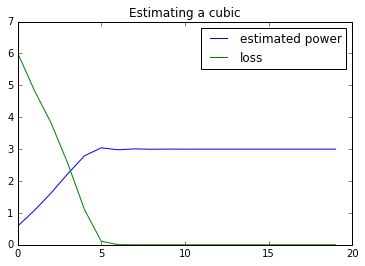

In [25]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3
data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                         target=power,
                                         initial_guess=0,
                                         learning_rate=.25,
                                         training_data=data_dict,
                                         num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title('Estimating a cubic')

#ok -- now the result stably converges!

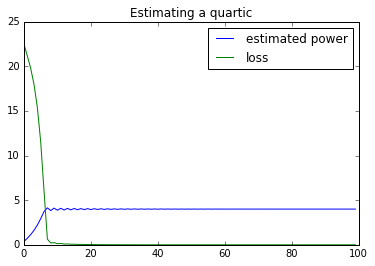

In [26]:
#and also for a higher power .... 
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**4
data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                         target=power,
                                         initial_guess=0,
                                         learning_rate=0.1,
                                         training_data=data_dict,
                                         num_iterations=100)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title('Estimating a quartic')

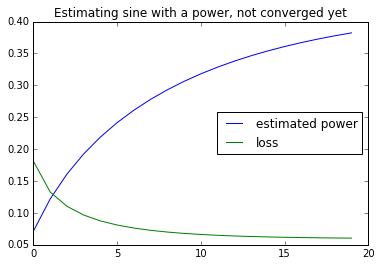

In [27]:
#what about when the data is actually not of the right form?

xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                          target=power,
                                          initial_guess=0,
                                          learning_rate=0.1,
                                          training_data=data_dict,
                                          num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
plt.title('Estimating sine with a power, not converged yet')

#doesn't look like it's converged yet -- maybe we need to run it longer? 

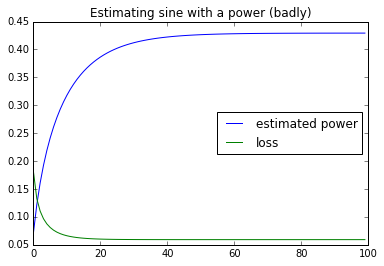

In [28]:
#sine(x) now with more iterations

xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, powers, grads = gradient_descent(loss=power_loss,
                                        target=power,
                                        initial_guess=0,
                                        learning_rate=0.1,
                                        training_data=data_dict,
                                        num_iterations=100)  #<-- more iterations

plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
plt.title('Estimating sine with a power (badly)')

#ok it's converged but not to a great loss.  This is unsurprising 
#since x^p is a bad model for sine(x)

In [29]:
#how should we improve? 
#THE MACHINE LEARNING ANSWER:  well, let's have more parameters in our model!

#actually, let's write a model using the Taylor series idea more explicitly:
#    y ~ sum_i a_i x^i  
#for some coefficients a_i that we have to learn

In [30]:
#let's go out to x^5, so approx_order = 7 (remember, we're 0-indexing in python)
approximation_order = 6

#ok so now let's define the variabe we'll be using
#instead of "power" this will be coefficients of the powers
#with one coefficient for each power from 0 to approximation_order-1
coefficients = tf.get_variable('coefficients', 
                        initializer = tf.zeros(shape=(approximation_order,)),
                        dtype=tf.float32)

In [31]:
#gotta run the initializer again b/c we just defined a new trainable variable
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [32]:
sess.run(coefficients)

array([ 0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [33]:
#Ok let's define the model

#here's the vector of exponents
powervec = tf.range(0, approximation_order, dtype=tf.float32)

#we want to do essentially:
#     sum_i coefficient_i * x^powervec[i]
#but to do x^powervec, we need to create an additional dimension on x
x_expanded = tf.expand_dims(x, axis=1)

#ok, now we can actually do x^powervec
x_exponentiated = x_expanded**powervec

#now multiply by the coefficient variable
x_multiplied_by_coefficients = coefficients * x_exponentiated

#and add up over the 1st dimension e.g. dong the sum_i
polynomial_model = tf.reduce_sum(x_multiplied_by_coefficients, axis=1)

#the loss is again l2 difference between prediction and desired output
polynomial_loss = tf.reduce_mean((polynomial_model - y)**2)

In [34]:
xval = np.arange(-2, 2, .02)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

#starting out at 0 since the coefficients were all intialized to 0
sess.run(polynomial_model, feed_dict=data_dict)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [35]:
#ok let's try it
losses, coefvals, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.1,  
                                        training_data=data_dict,
                                        num_iterations=100)  


In [36]:
#ok, so for each timstep we have 6 values -- the coefficients
print(len(coefvals))

coefvals[-1].shape

100


(6,)

In [37]:
#here's the last set of coefficients learned
coefvals[-1]
#whoa -- what's going on?  

array([ nan,  nan,  nan,  nan,  nan,  nan], dtype=float32)

In [38]:
#let's lower the learning rate
losses, coefvals, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.005,  #<-- lowered learning rate
                                        training_data=data_dict,
                                        num_iterations=100)  


In [39]:
#ok not quite as bad
coefvals[-1]

array([-0.00102979,  0.25239715, -0.00184434,  0.20770763,  0.00133661,
       -0.032684  ], dtype=float32)

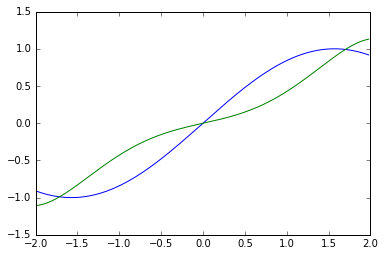

In [40]:
#let's visualize what we learned
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.plot(xval, yval)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))


#ok, fine, but not great

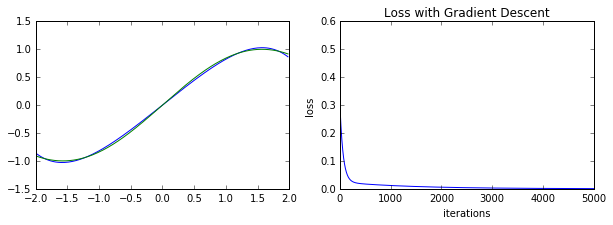

In [41]:
#what if we let it run longer? 
losses, coefvals, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.005,  
                                        training_data=data_dict,
                                        num_iterations=5000)  #<-- more iterations

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Gradient Descent')


#ok much better

In [42]:
coefvals[-1]

array([-0.00102551,  0.90462953,  0.0028135 , -0.07157703, -0.00094981,
       -0.01200764], dtype=float32)

In [43]:
tf.Variable(np.zeros(6))

<tf.Variable 'Variable:0' shape=(6,) dtype=float64_ref>

In [44]:
def gradient_descent_with_momentum(loss, 
                     target,
                     initial_guess,
                     learning_rate,
                     momentum,
                     training_data,
                     num_iterations):
    
    #set target to initial guess
    initial_op = tf.assign(target, initial_guess)
    #get gradient
    grad = tf.gradients(loss, target)[0]
    #set up the variable for the gradient accumulation
    grad_shp = grad.shape.as_list()
    #needs to be specified as float32 to interact properly with other things (but numpy defaults to float64)
    grad_accum = tf.Variable(np.zeros(grad_shp).astype(np.float32))
    #gradplus = grad + momentum * grad_accum
    gradplus = tf.add(grad, tf.multiply(grad_accum, momentum))
    #newval = oldval - learning_rate * gradplus
    newval = tf.add(target, tf.multiply(-gradplus, learning_rate))
    #the optimizer step actually performs the parameter update
    optimizer_op = tf.assign(target, newval)
    #this step updates grad_accum 
    update_accum = tf.assign(grad_accum, gradplus)
    
    #run initialization
    sess.run(initial_op)
    #necessary b/c we've defined a new variable ("grad_accum") above
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    #run the loop
    targetvals = []
    losses = []
    gradvals = []  
    times = []
    for i in range(num_iterations):
        t0 = time.time()
        output = sess.run({'opt': optimizer_op, #have to have this for optimization to occur
                           'accum': update_accum, #have to have this for grad_accum to update
                           'grad': grad, #the rest of these are just for keeping track
                           'target': target,  
                           'loss': loss
                          }, 
                          feed_dict=training_data)
        times.append(time.time() - t0)
        targetvals.append(output['target'])
        losses.append(output['loss'])
        gradvals.append(output['grad'])
                
    print('Average time per iteration --> %.5f' % np.mean(times))
    return losses, targetvals, gradvals
    

Average time per iteration --> 0.00134


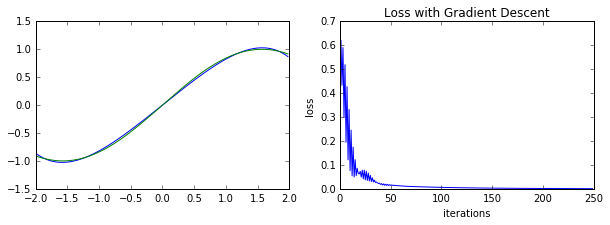

In [45]:
losses, coefvals, grads = gradient_descent_with_momentum(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        learning_rate=0.01,  #<-- can use higher learning rate!
                                        momentum=0.9,
                                        training_data=data_dict,
                                        num_iterations=250)  #<-- can get away from fewer iterations!

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Gradient Descent')

#so momentum is really useful 

### Tensorflow's Built-In Optimizers

In [46]:
def tf_builtin_optimization(loss,
                            optimizer_class,
                            target,
                            training_data,
                            num_iterations,
                            optimizer_args=(),
                            optimizer_kwargs={},
                           ):
    
    #construct the optimizer
    optimizer = optimizer_class(*optimizer_args, 
                                **optimizer_kwargs)
    #formal tensorflow optimizers will always have a "minimize" method
    #this is how you actually get the optimizer op
    optimizer_op = optimizer.minimize(loss)
    
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    targetvals = []
    losses = []
    times = []
    for i in range(num_iterations):
        t0 = time.time()
        output = sess.run({'opt': optimizer_op,
                           'target': target,
                           'loss': loss}, 
                          feed_dict=training_data)
        times.append(time.time() - t0)
        targetvals.append(output['target'])
        losses.append(output['loss'])
    
    print('Average time per iteration --> %.5f' % np.mean(times))
    return np.array(losses), targetvals

Average time per iteration --> 0.00125


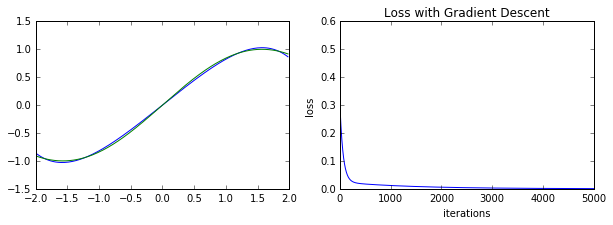

In [47]:
xval = np.arange(-2, 2, .02)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.GradientDescentOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=5000,
                              optimizer_args=(0.005,),
                              )  #<-- more iterations

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Gradient Descent')


#right ok, we recovered what we did before by hand, now using
#the standard tensorflow tools

Average time per iteration --> 0.00133


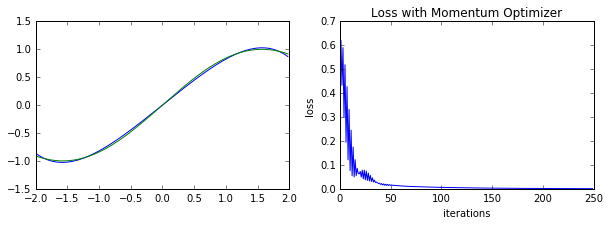

In [48]:
#Let's use the Momentum Optimizer. standard parameters for learning 
#are learning_rate = 0.01 and momentum = 0.9

xval = np.arange(-2, 2, .02)
yval = np.sin(xval )
data_dict = {x: xval, y:yval}

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.MomentumOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=250, 
                              optimizer_kwargs={'learning_rate': 0.01,
                                                'momentum': 0.9}) 
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Momentum Optimizer')

#again reproducing what we see before by hand

Average time per iteration --> 0.00146


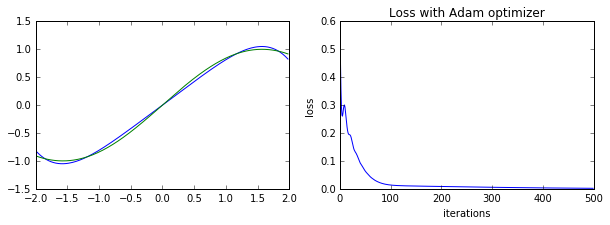

In [49]:
#and we can try some other stuff, such as the Adam Optimizer

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.AdamOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=500,
                              optimizer_kwargs={'learning_rate': 0.01})                                            
                            
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Adam optimizer')

#Adam as usualy requires a bit more steps than Momentum -- but the advantage of Adam
#is that sometimes Momentum blows up and Adam is usually more stable
#(compare the loss traces! even though Momentum didn't below up above, it's
#loss is much more jaggedy -- signs up potential blowup)

Average time per iteration --> 0.00169


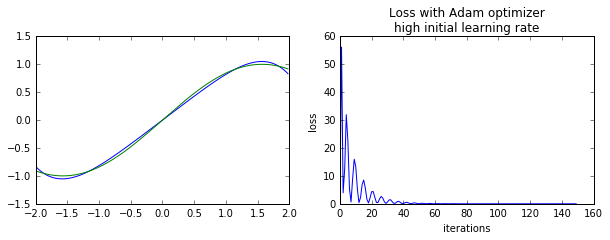

In [50]:
#so hm ... maybe because Adam is more stable we can jack up the 
#initial learning rate and thus converge even faster than with Momentum

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.AdamOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=150,
                              optimizer_kwargs={'learning_rate': 0.5})                                            
                            
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))
plt.plot(xval, yval)

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Adam optimizer\nhigh initial learning rate')

#indeed we can!

### Newton's Method  (Second Order)

In [51]:
def newtons_method(loss, 
                   target,
                   initial_guess,
                   training_data,
                   num_iterations,
                   grad2clip=1.):
    
    #create initialization operation
    initial_op = tf.assign(target, initial_guess)    

    grad = tf.gradients(loss, target)[0]
    #to actually compute the second order correction 
    #we split the one-variable and multi-variable cases up -- for ease of working
    
    if len(target.shape) == 0:   #one-variable case
        #actually get the second derivative
        grad2 = tf.gradients(grad, target)[0]
        
        #now morally we want to compute:
        #    newval = target - grad / grad2
        #BUT there is often numerical instability caused by dividing
        #by grad2 if grad2 is small... so we have to clip grad2 by a clip value
        clippedgrad2 = tf.maximum(grad2, grad2clip)
        
        #and now we can do the newton's formula update
        newval = tf.add(target, -tf.divide(grad, clippedgrad2))
    else:
        #in the multi-variable case, we first compute the hessian matrix
        #thank gosh tensorflow has this built in finally!
        hess = tf.hessians(loss, target)[0]
        #now we take it's inverse
        hess_inv = tf.matrix_inverse(hess)
        #now we get H^{-1} grad, e.g. multiple the matrix by the vector
        hess_inv_grad = tf.tensordot(hess_inv, grad, 1)
        #again we have to clip for numerical stability
        hess_inv_grad = tf.clip_by_value(hess_inv_grad, -grad2clip, grad2clip)
        #and get the new value for the parameters
        newval = tf.add(target, -hess_inv_grad)
    
    #the rest of the code is just as in the gradient descent case
    optimizer_op = tf.assign(target, newval)    
    targetvals = []
    losses = []
    gradvals = []
    sess.run(initial_op)
    for i in range(num_iterations):        
        output = sess.run({'opt': optimizer_op,
                           'grad': grad, 
                           'target': target,
                           'loss': loss}, 
                          feed_dict=training_data)
        targetvals.append(output['target'])
        losses.append(output['loss'])
        gradvals.append(output['grad'])
    return losses, targetvals, gradvals


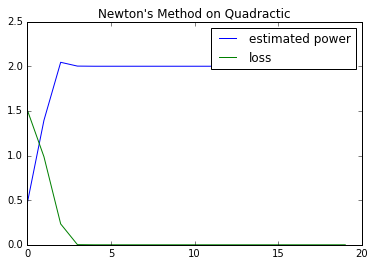

In [52]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2
data_dict = {x: xval, y:yval}

losses, powers, grads = newtons_method(loss=power_loss,
                                       target=power,
                                       initial_guess=0,
                                       training_data=data_dict,
                                       num_iterations=20,
                                       grad2clip=1)


plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title("Newton's Method on Quadractic")

#whoa -- much faster than before

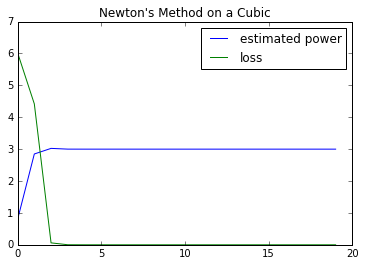

In [53]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3
data_dict = {x: xval, y:yval}

losses, powers, grads = newtons_method(loss=power_loss,
                                       target=power,
                                       initial_guess=0,
                                       training_data=data_dict,
                                       num_iterations=20,
                                       grad2clip=1)


plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title("Newton's Method on a Cubic")


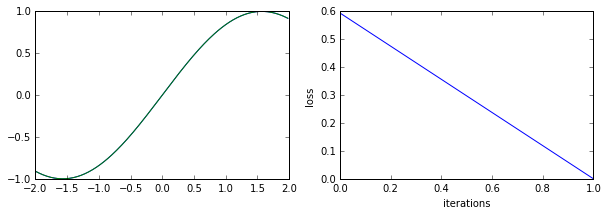

In [54]:
xval = np.arange(-2, 2, .02)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

losses, coefvals, grads = newtons_method(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        training_data=data_dict,
                                        num_iterations=2)

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, yval)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))


plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

#no joke -- the error goes to 0 after 1 update step


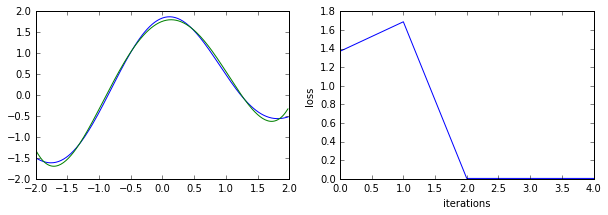

In [55]:
#let's try something a little more complicated 

xval = np.arange(-2, 2, .02)
yval = np.cos(2 * xval) + np.sin(xval + 1)

data_dict = {x: xval, y:yval}

losses, coefvals, grads = newtons_method(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.zeros(approximation_order),
                                        training_data=data_dict,
                                        num_iterations=5)

x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, yval)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))


plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

#really fast -- actually Newton's method always converges this fast if
#the model is polynomial


Average time per iteration --> 0.00107


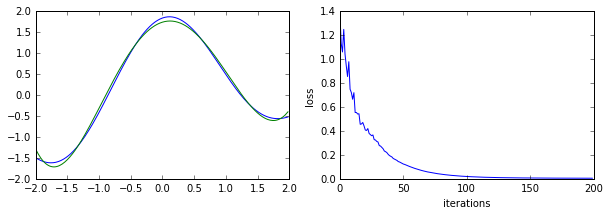

In [56]:
#just to put the above in context, let's compare to momentum

xval = np.arange(-2, 2, .02)
yval = np.cos(2 * xval) + np.sin(xval + 1)

data_dict = {x: xval, y:yval}

losses, coefvals = tf_builtin_optimization(loss=polynomial_loss,
                              optimizer_class=tf.train.MomentumOptimizer,
                              target=coefficients,
                              training_data=data_dict,
                              num_iterations=200,
                              optimizer_kwargs={'learning_rate': 0.01,
                                                'momentum': 0.9},
                              ) 
x0 = coefvals[-1]
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, yval)
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}))


plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')

### Using External Optimizers

In [59]:
#actually, let's use an *external* optimizer -- not do 
#the optimization itself in tensorflow
from scipy.optimize import minimize

#you can see all the methods for optimization here:  
#   https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

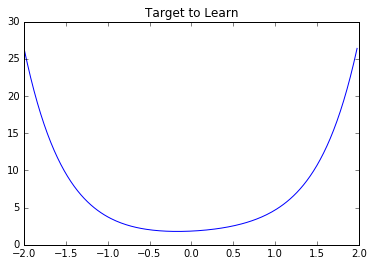

In [60]:
#Ok here's the model we want to learn
xval = np.arange(-2, 2, .02)
yval = np.cosh(2 * xval) + np.sin(xval + 1)

plt.plot(xval, yval)
plt.title("Target to Learn")

In [61]:
polynomial_loss

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [62]:
#we need to make a python function from our tensorflow model
#(actually we could simply write the model directly in numpy
#but ... since we already have it in Tensorflow might as well use it

def func_loss(vals):
    data_dict = {x: xval, 
                 y: yval,
                 coefficients: vals}
    lossval = sess.run(polynomial_loss, feed_dict=data_dict)
    losses.append(lossval)
    return lossval

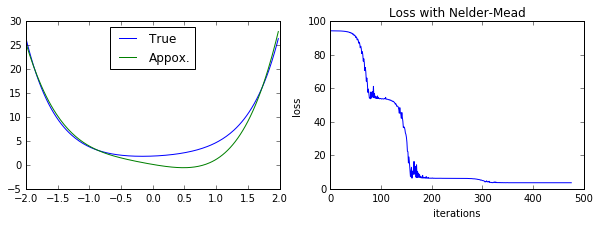

In [63]:
#Ok, so let's use a method that doesn't care about the derivative
#specifically "Nelder-Mead" -- this is a simplex-based method

losses = []
result = minimize(func_loss, 
                  x0=np.zeros(6),
                  method='Nelder-Mead')

x0 = result.x
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, yval, label='True')
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}), label='Appox.')
plt.legend(loc='upper center')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with Nelder-Mead')


In [64]:
#OK now let's try a method that *does* care about the derivative
#specifically, a method called L-BFGS -- this is basically 
#an approximate version of the newton's method. 
#It's called a "quasi-second-order" method because it uses only 
#first derivatives to get an approximation to the second derivative

#to use it, we need *do* need to calculate the derivative
#... and here's why tensorflow STILL matters even if we're using 
#an external optimizer

polynomial_grad = tf.gradients(polynomial_loss, coefficients)[0]

In [65]:
#we need to create a function that returns loss and loss derivative
def func_loss_with_grad(vals):
    data_dict = {x: xval, 
                 y:yval,
                 coefficients: vals}
    lossval, g = sess.run([polynomial_loss, polynomial_grad], 
                    feed_dict=data_dict)
    losses.append(lossval)
    return lossval, g.astype(np.float64)

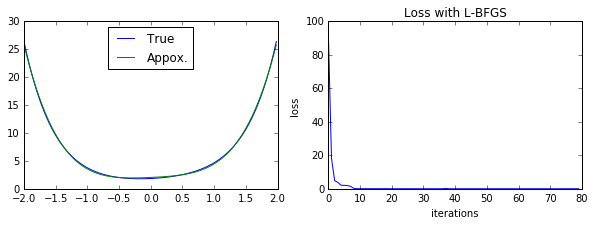

In [66]:
#Ok, so let's see what happens with L-BFGS
losses = []
result = minimize(func_loss_with_grad, 
                  x0=np.zeros(6),
                  method='L-BFGS-B', #approximation of newton's method
                  jac=True  #<-- meaning, we're telling minimizer 
                            #to use the derivative info -- the so-called
                            #"jacobian"
                 )

x0 = result.x
assign_op = tf.assign(coefficients, x0)
sess.run(assign_op)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.plot(xval, yval, label='True')
plt.plot(xval, sess.run(polynomial_model, feed_dict={x:xval}), label='Appox.')
plt.legend(loc='upper center')

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss with L-BFGS')

#substantially better than the non-derivative-based method
#-- fewer interations are needed, loss curve is stabler, and final 
#results are better


## Deploying it in a real case

In [67]:
#ok let's load the neural data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)

var_levels = Ventral_Dataset['image_meta']['variation_level'][:] 

Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]

num_neurons = Neural_Data.shape[1]
num_categories = 8 

In [68]:
categories[:10]

array(['Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits',
       'Fruits', 'Fruits', 'Fruits', 'Fruits'],
      dtype='|S7')

In [69]:
#we'll construct 8 one-vs-all vectors with {-1, 1} values
category_matrix = np.array([2 * (categories == c) - 1 for 
                             c in unique_categories]).T.astype(int)

In [70]:
category_matrix[0]

array([-1, -1, -1, -1, -1,  1, -1, -1])

In [71]:
sess = tf.Session()

In [72]:
#first, get initializers for W and b
initial_weights = tf.random_uniform(shape=(num_neurons, num_categories),
                  minval=-1,
                  maxval=1,
                  seed=0)

initial_bias = tf.zeros(shape=(num_categories,))

In [73]:
#now construct the TF variables
weights = tf.get_variable('weights', 
                           dtype=tf.float32,
                           initializer=initial_weights)
                         
bias = tf.get_variable('bias', 
                       dtype=tf.float32,
                       initializer=initial_bias)#initialize variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [74]:
#input slots for data and labels
#note the batch size is "None" -- effectively meaning batches of 
#varying sizes can be used
neural_data = tf.placeholder(shape=(None, num_neurons),
                              dtype=tf.float32)

category_labels = tf.placeholder(shape=(None, num_categories),
                                 dtype=tf.float32)

In [75]:
#now construct margins
margins = tf.matmul(neural_data, weights) + bias

#the hinge loss
hinge_loss = tf.maximum(0., 1. - category_labels * margins)

#and take the mean of the loss over the batch
hinge_loss_mean = tf.reduce_mean(hinge_loss)

In [76]:
#simple interface for using tensorflow built-in optimizer
#as seen yesterclass

def tf_optimize(loss,
                optimizer_class,
                target,
                training_data,
                num_iterations,
                optimizer_args=(),
                optimizer_kwargs=None,
                sess=None,
                initial_guesses=None):
                           
    if sess is None:
        sess = tf.Session()
        
    if optimizer_kwargs is None:
        optimizer_kwargs = {}
    
    #construct the optimizer
    optimizer = optimizer_class(*optimizer_args, 
                                **optimizer_kwargs)
    optimizer_op = optimizer.minimize(loss)
    
    #initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    
    if initial_guesses is not None:
        for k, v in initial_guesses.items():
            op = tf.assign(k, v)
            sess.run(op)

    targetvals = []
    losses = []
    times = []
    for i in range(num_iterations):
        t0 = time.time()
        output = sess.run({'opt': optimizer_op,
                           'target': target,
                           'loss': loss}, 
                           feed_dict=training_data)
        times.append(time.time() - t0)
        targetvals.append(output['target'])
        losses.append(output['loss'])
    
    print('Average time per iteration --> %.5f' % np.mean(times))
    return np.array(losses), targetvals

In [77]:
#let's just focus on one batch of data for the moment

batch_size = 640
data_batch = Neural_Data[0: batch_size]
label_batch = category_matrix[0: batch_size]

data_dict = {neural_data: data_batch,
             category_labels: label_batch}

('weights shape:', (296, 8))
('biases:', array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32))


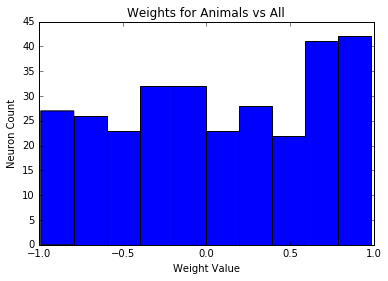

In [78]:
#let's look at the weights and biases before training
weight_vals, bias_vals = sess.run([weights, bias])

#right, it's num_neurons x num_categories
print('weights shape:', weight_vals.shape)

#let's look at some of the weights
plt.hist(weight_vals[:, 0])
plt.xlabel('Weight Value')
plt.ylabel('Neuron Count')
plt.title('Weights for Animals vs All')

print('biases:', bias_vals)

In [79]:
#ok so we'll use the Momentum optimizer to find weights and bias
#for this classification problem
losses, targs = tf_optimize(loss=hinge_loss_mean,
            optimizer_class=tf.train.MomentumOptimizer,
            target=[],
            training_data=data_dict,
            num_iterations=100,
            optimizer_kwargs={'learning_rate': 1, 'momentum': 0.9},
            sess=sess)

Average time per iteration --> 0.00345


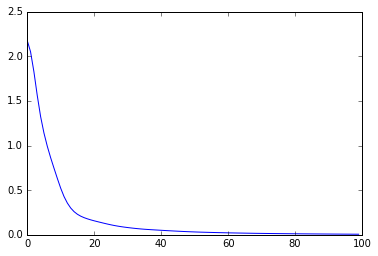

In [80]:
#losses decrease almost to 0
plt.plot(losses)

('biases:', array([-5.6579237 , -5.38999081, -6.01903248, -5.87763357, -5.83938694,
       -5.5426507 , -5.03545904, -5.47604179], dtype=float32))


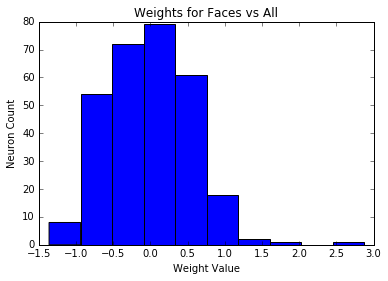

In [81]:
weight_vals, bias_vals = sess.run([weights, bias])

#right, it's num_neurons x num_categories
weight_vals.shape

#let's look at some of the weights
plt.hist(weight_vals[:, 2])
plt.xlabel('Weight Value')
plt.ylabel('Neuron Count')
plt.title('Weights for Faces vs All')

print('biases:', bias_vals)

#ok so things have been learned!

In [82]:
#how good are the results on training? 

#actually get the predictions by first getting the margins
margin_vals = sess.run(margins, feed_dict = data_dict)
#now taking the argmax across categories
pred_inds = margin_vals.argmax(axis=1)
#compare prediction to actual
correct = pred_inds == label_batch.argmax(axis=1)
pct = correct.sum() / float(len(correct)) * 100
print('Training accuracy: %.2f%%' % pct)

#Right, very accurate on training

Training accuracy: 99.53%


### Stochastic Gradient Descent

In [83]:
import optimizer as opt

In [84]:
dir(opt)

['BatchReader',
 'TF_Optimizer',
 '__builtins__',
 '__doc__',
 '__file__',
 '__name__',
 '__package__',
 'np',
 'tf']

In [85]:
opt.TF_Optimizer?

In [92]:
def binarize_labels(labels):
    """takes discrete-valued labels and binarizes them into {-1, 1}-value format
       returns:
           binarized_labels: of shape (num_stimuli, num_categories)
           unique_labels: actual labels indicating order of first axis in binarized_labels
    """
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    binarized_labels = np.array([2 * (labels == c) - 1 for 
                                    c in unique_labels]).T.astype(int)
    return binarized_labels, unique_labels
    

class TF_OVA_Classifier(opt.TF_Optimizer):
    """
    Subclass of TFOptimizer for use with categorizers. Basically, this class 
    handles data binarization (in the fit method) and un-binarization 
    (in the predict method), so that we can use the class with the function:
    
         train_and_test_scikit_classifier
    
    that we've previously defined. 
    
    The predict method here implements a one-vs-all approach for multi-class problems.
    """
    
    def fit(self, train_data, train_labels):
        #binarize labels
        num_features = train_data.shape[1]
        binarized_labels, classes_ = binarize_labels(train_labels)
        #set .classes_ attribute, since this is needed by train_and_test_scikit_classifier
        self.classes_ = classes_
        num_classes = len(classes_)
        #pass number of features and classes to the model construction 
        #function that will be called when the fit method is called
        self.model_kwargs['num_features'] = num_features
        self.model_kwargs['num_classes'] = num_classes
        #now actually call the optimizer fit method
        opt.TF_Optimizer.fit(self, 
                             train_data=train_data, 
                             train_labels=binarized_labels)
  
    def decision_function(self, test_data):
        #returns what are effectively the margins (for a linear classifier)
        return opt.TF_Optimizer.predict(self, test_data)
    
    def predict(self, test_data):
        #use the one-vs-all rule for multiclass prediction. 
        preds = self.decision_function(test_data)
        preds = np.argmax(preds, axis=1)
        classes_ = self.classes_
        return classes_[preds]

In [96]:
reload(opt)

<module 'optimizer' from 'optimizer.py'>

In [97]:
def linear_classifier(num_features, num_classes):
    """generic form of a linear classifier, e.g. the model
          margins = np.dot(data, weight) + bias
    """
    initial_weights = tf.zeros(shape=(num_features, 
                                      num_classes), 
                               dtype=tf.float32)
    weights = tf.Variable(initial_weights, 
                          dtype=tf.float32,
                          name='weights')
    initial_bias = tf.zeros(shape=(num_classes,))
    bias = tf.Variable(initial_bias, 
                       dtype=tf.float32,
                       name='bias')
                           
    data = tf.placeholder(shape=(None, num_features), dtype=tf.float32, name='data')
    margins = tf.add(tf.matmul(data, weights), bias, name='margins')
    return margins, data


def hinge_loss(margins):
    """standard SVM hinge loss
    """
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    h = tf.maximum(0., 1. - category_labels * margins, name='hinge_loss')
    hinge_loss_mean = tf.reduce_mean(h, name='hinge_loss_mean')
    return hinge_loss_mean, category_labels

In [98]:
#construct the classifier instance ... just like with scikit-learn
cls = TF_OVA_Classifier(model_func=linear_classifier,
              loss_func=hinge_loss, 
              batch_size=2500,
              train_iterations=1000,
              train_shuffle=True,
              optimizer_class=tf.train.MomentumOptimizer,
              optimizer_kwargs = {'learning_rate':10.,
                                  'momentum': 0.99
                                 },
              sess=sess
              )

In [99]:
#ok let's try out our classifier on medium-variation data
data_subset = Neural_Data[var_levels=='V3']
categories_subset = categories[var_levels=='V3']

cls.fit(data_subset, categories_subset)

plt.plot(cls.losses)
plt.xlabel('number of iterations')
plt.ylabel('Hinge loss')

TypeError: unbound method fit() must be called with TF_Optimizer instance as first argument (got TF_OVA_Classifier instance instead)

In [ ]:
#ok how good was the actual training accuracy? 
preds = cls.predict(data_subset)
acc = (preds == categories_subset).sum()
pct = acc / float(len(preds)) * 100

print('Training accuracy was %.2f%%' % pct)

#### Side note on getting relevant tensors

In [ ]:
#here's the linear mode constructed above:
lin_model = cls.model
print(lin_model)

In [ ]:
#suppose we want to access the weights / bias used in this model?
#these can be accessed by the "op.inputs" attribute in TF

#first, we see that this is the stage of the caluation
#where the linear model (the margins) is put together by adding 
#the result of the matrix multiplication ("MatMul_[somenumber]")
#to the bias
list(lin_model.op.inputs)

In [ ]:
#so bias is just the first of these inputs
bias_tensor = lin_model.op.inputs[1]
bias_tensor

In [ ]:
#if we follow up the calculation graph by taking apart
#whatever was the inputs to the matmul stage, we see
#the data and the weights
matmul_tensor = lin_model.op.inputs[0]
list(matmul_tensor.op.inputs)

In [ ]:
#so the weights tensor is just the first of *these* inputs
weights_tensor = matmul_tensor.op.inputs[1]
weights_tensor

In [ ]:
#putting this together, we could have done:
weights_tensor = lin_model.op.inputs[0].op.inputs[1]
weights_tensor

In [ ]:
#### Regularization

In [ ]:
#we can define other loss functions -- such as L2 regularization

def hinge_loss_l2reg(margins, C, square=False):
    #starts off the same as regular hinge loss
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    h = tf.maximum(0., 1 - category_labels * margins)
    #allows for squaring the hinge_loss optionally, as done in sklearn
    if square:
        h = h**2
    hinge_loss = tf.reduce_mean(h)
    
    #but how let's get the weights from the margins,
    #using the method just explored above
    weights = margins.op.inputs[0].op.inputs[1]
    #and get sum-square of the weights -- the 0.5 is for historical reasons
    reg_loss = 0.5*tf.reduce_mean(weights**2) 
    
    #total up the loss from the two terms with constant C for weighting 
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss, category_labels

In [ ]:
cls = TF_OVA_Classifier(model_func=linear_classifier,
              loss_func=hinge_loss_l2reg, 
              loss_kwargs={'C':1},
              batch_size=2500,
              train_iterations=1000,
              train_shuffle=True,
              optimizer_class=tf.train.MomentumOptimizer,
              optimizer_kwargs = {'learning_rate':10.,
                                  'momentum': 0.99
                                 },
              sess=sess,
              )

In [ ]:
data_subset = Neural_Data[var_levels=='V3']
categories_subset = categories[var_levels=='V3']

cls.fit(data_subset, categories_subset)

plt.plot(cls.losses)
plt.xlabel('number of iterations')
plt.ylabel('Regularized Hinge loss')

preds = cls.predict(data_subset)
acc = (preds == categories_subset).sum()
pct = acc / float(len(preds)) * 100

print('Regularized training accuracy was %.2f%%' % pct)

#unsuprisingly training accuracy goes down a bit with regularization
#compared to before w/o regularization

In [ ]:
### Integrating with cross validation tools

In [ ]:
import cross_validation as cv

In [ ]:
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

In [ ]:
#the whole point of creating the TF_OVA_Classifier above
#was that we could simply stick it into the cross-validation regime
#that we'd previously set up for scikit-learn style classifiers
#so now let's test it out

#create some train/test splits
splits = cv.get_splits(meta_array, 
              lambda x: x['object_name'],  #we're balancing splits by object
              5,  
              5,  
              35,  
              train_filter=lambda x: (x['variation_level'] == 'V3'),
              test_filter=lambda x: (x['variation_level'] == 'V3'),)
    
    
#here are the arguments to the classifier
model_args = {'model_func': linear_classifier,
              'loss_func': hinge_loss_l2reg, 
              'loss_kwargs': {'C':5e-2, #<-- a good regularization value
                             },   
              'batch_size': 2500,
              'train_iterations': 1000,  #<-- about the right number of steps
              'train_shuffle': True,
              'optimizer_class':tf.train.MomentumOptimizer,
              'optimizer_kwargs': {'learning_rate':.1,
                                   'momentum': 0.9},
              'sess': sess}

#so now it should work just like before
res = cv.train_and_test_scikit_classifier(features=Neural_Data,
                                       labels=categories,
                                       splits=splits,
                                       model_class=TF_OVA_Classifier,
                                       model_args=model_args)


In [ ]:
#yep!
res[0]['test']['mean_accuracy']

In [ ]:
#### Logistic Regression with Softmax loss 

In [ ]:
def softmax_loss_l2reg(margins, C):
    """this shows how to write softmax logistic regression 
       using tensorflow
    """
    num_classes = margins.shape.as_list()[1]
    category_labels = tf.placeholder(shape=(None, num_classes),
                                     dtype=tf.float32, 
                                     name='labels')
    
    #get the softmax from the margins
    probs = tf.nn.softmax(margins) 
    #extract just the prob value for the correct category
    #(we have the (cats + 1)/2 thing because the category_labels
    #come in as {-1, +1} values but we need {0,1} for this purpose)
    probs_cat_vec = probs * ((category_labels + 1.) / 2.)
    #sum up over categories (actually only one term, that for
    #the correct category, contributes on each row)
    probs_cat = tf.reduce_mean(probs_cat_vec, axis=1)
    #-log 
    neglogprob = -tf.log(probs_cat)
    #average over the batch
    log_loss = tf.reduce_mean(neglogprob)
    
    weights = cls.model.op.inputs[0].op.inputs[1]
    reg_loss = 0.5*tf.reduce_mean(tf.square(weights)) 
    
    total_loss = C * log_loss + reg_loss
    return total_loss, category_labels

In [ ]:
model_args={'model_func': linear_classifier,
            'model_kwargs': {},
            'loss_func': softmax_loss_l2reg, 
            'loss_kwargs': {'C': 5e-3},
            'batch_size': 2500,
            'train_iterations': 1000,
            'train_shuffle': True,
            'optimizer_class':tf.train.MomentumOptimizer,
            'optimizer_kwargs': {'learning_rate': 1.,
                                 'momentum': 0.9
                                 },
            'sess': sess}

res = cv.train_and_test_scikit_classifier(features=Neural_Data,
                                       labels=categories,
                                       splits=splits,
                                       model_class=TF_OVA_Classifier,
                                       model_args=model_args)


In [ ]:
res[0]['test']['mean_accuracy']
#ok works reasonably well